<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/Neural_captioning_using_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import string


In [ ]:
# download the captions
annotation_folder = '/annotations'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


252878848/252872794 [==============================] - 6s 0us/step


In [ ]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder


13510574080/13510573713 [==============================] - 323s 0us/step


In [ ]:
annotation_file = "/content/annotations/captions_train2014.json"

In [ ]:
with open(annotation_file,'r') as f:
  annotations = json.load(f)
  

In [ ]:
# preprocessing the captions

table = str.maketrans('', '', string.punctuation)
all_captions = [] # a list containing all the captions 
all_img_name_vector = [] # the corresponding image path for the captions

for annot in annotations['annotations']:
  # the caption
  caption = annot["caption"]
  # split from space
  caption = caption.split()
  # convert to lower case
  caption = [word.lower() for word in caption]
  # remove punctuation from each token
  caption = [w.translate(table) for w in caption]
  # remove hanging 's' and 'a'
  caption = [word for word in caption if len(word)>1]
  # remove tokens with numbers in them
  caption = [word for word in caption if word.isalpha()]
  # store as string
  caption =  ' '.join(caption)
  # adding start and end token
  caption = "<start> " + caption + " <end>"
  image_id = annot["image_id"]
  full_coco_image_path = PATH + "COCO_train2014_" + "%012d.jpg" % (image_id) # the corresponding image path
  all_captions.append(caption)
  all_img_name_vector.append(full_coco_image_path)


In [ ]:
# shuffle captions and corresponding images together
captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)


In [ ]:
# select the first 50,000 captions and their corresponding images 
num_examples = 50000
train_captions = captions[:num_examples]# (its a list) of captions
img_name_vector = img_name_vector[:num_examples] # (its a list) of image paths


In [ ]:
type(img_name_vector)


list

In [ ]:
# using inception v3 trained on imagenet as a fixed feature extractor for our images (transfer learning)
# we will extract features from the last conv layer 8x8x2048

# converting our caption images into inceptoin v3's format ie 299x299 and normalization
def load_image(image_path):
  img = tf.io.read_file(image_path) # reads the contents at the image_path
  img = tf.image.decode_jpeg(img,channels=3) # converts the jpeg format into a tensor (3 channel)
  img = tf.image.resize(img,(299,299)) # resizing the image to 299x299 to meet inceptions requirements
  img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocesses the resized img to inceptions req
  # normalize the img and all
  return img,image_path
  

In [ ]:
# now we initialize the inceptionv3 and its trained weights on imagenet
image_model = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet") # loading the model and weights
new_input = image_model.input # the input layer
hidden_layer = image_model.layers[-1].output # the last conv output layer for fixed feature extraction

# model which inputs image and outputs 8x8x2048 features for the image using the inceptionv3 + its weights
image_features_ectract_model =  tf.keras.Model(new_input, hidden_layer) 


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
!pip install -q tqdm
from tqdm import tqdm


In [ ]:
# now we extract the featues for each image and  cache the output to disk.

# since img_name_vectors may contain the same image twice, we only need to get the uniqe images once
encode_train = sorted(set(img_name_vector)) # unique images (theyre actually the paths of the unique images)

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train) # an iterable of the unique image paths


#This transformation applies load_image func to each uniqe image path  of th image_dataset, 
#and returns a new dataset containing the tuples (64 image_tensors, 64 img_paths), 
#in the same order as they appeared in the img_dataset. 

image_dataset = image_dataset.map(map_func=load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)


In [ ]:
for img,path in tqdm(image_dataset):
  batch_features  = image_features_ectract_model(img) # passing the images (a batch of 64) throught the inceptionv3 to extract the feeatures
  # batch_size, filter_size_1, filter_size_2, channels = batch_features.shape
  for feature, p in zip(batch_features,path):
    path_of_feature = p.numpy().decode("utf-8") # image path of the corresponding extracted feature of image
    np.save(path_of_feature, feature.numpy())


100%|██████████| 613/613 [08:33<00:00,  1.19it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# tokenizing and then mapping the tokens to the embeddings

# downloading the glove word embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
# unzipping the embeddings
!unzip glove*.zip


--2020-08-06 04:22:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-06 04:22:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-06 04:22:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# creating a vocabulary with only the top 5000 words appearing in the training set
# all other words get replaced by "<unk>" token
top_k = 5000 # vocab of top 5000 words as appearing in the training set

#tokenizer object, oov=<unk>
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ', oov_token="<unk>")

tokenizer.fit_on_texts(train_captions) # creating the vocabulary of the 5000 most freq words in training set


In [ ]:
# adding "<pad>" as 0th index in the vocabulary
tokenizer.word_index["<pad>"] = 0
tokenizer.index_word[0] = "<pad>"


'<pad>'

In [ ]:
# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions) # returns the tokenized sentences (its a list)


In [ ]:
# zero padding the tokenized vectors (note that token: 0 <--> word: <pad> in the vocab) 
# returns zero padded (num_samples, max_len_of_captions) 2D tensor (tokenized)
caption_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding="post")


In [ ]:
max_length = caption_vector.shape[-1] # max length of the tokenized senntence 


In [ ]:
# now we have to create an embedding matrix of pretrainedd 300 dim embeddings 
# Load Glove vectors
glove_dir = '.'
word2vec_global = {}  # all the glove words mapped to their 300d vectors
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")
for line in f: # for each word
    values = line.split() # split word and embedding
    word = values[0].lower() # word in lower case
    embedding = np.asarray(values[1:], dtype='float32') # respective 300d embedding
    word2vec_global[word] = embedding
f.close()


In [ ]:
print(tokenizer.word_index.get("hello"))


3134


In [ ]:
# creating the embedding matrix
embedding_matrix = np.zeros((5001, 300)) # 5000 + 1 for zero padding, 300 embedding dims
for word, idx in tokenizer.word_index.items(): # for each word in vocab
  if idx > 5000: # do only till 5000 top words
    break
  embedding = word2vec_global.get(word) # get the embedding for that word
  if embedding is not None: # if that word exist in the glove data then add into embedding_matrix else...
    embedding_matrix[idx,:] = embedding
  else: # ... if it isnt in glove data, then the embedding corresponding to it is all zeros ! 
    pass 

# we have an emmbedding matrix ! awesome ! Dont forget to freeze this during making the model


In [ ]:
# lets split the data into 80% train 20% validation 
img_path_train, img_path_val, cap_train, cap_val = train_test_split(img_name_vector, caption_vector,test_size=0.2,random_state=0) 


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000 # in the ram, at any time, only 1000 image (tensor of image) will be stored
embedding_dim = 300 # glove
units = 512 
vocab_size = 5001 # 5000 + 1 for zero padding
num_steps = len(img_path_train)//BATCH_SIZE # number of steps per epoch in training

# Shape of the vector extracted from InceptionV3 is (64,8,8, 2048) and we will reshape into (64,8*8,2048)
# These two variables represent that vector shape
features_shape = 2048 # number of filters
attention_features_shape = 64 # number of neurons pers filter


In [ ]:
# func to load the numpy tensor of the corresponding caption
def map_func(img_path_name, caption):
  img_tensor = np.load(img_path_name.decode("utf-8") + '.npy')
  return img_tensor, caption
  

In [ ]:
# loading numpy tensor in parallel  

# dataset returns 1 img_path and its caption in one iter
dataset = tf.data.Dataset.from_tensor_slices((img_path_train,cap_train))


# this is a very neat method, please memorize this
# using map to load the numpy tensors  of the caption from the corresponding img_path 
dataset = dataset.map(lambda item1,item2: tf.numpy_function(map_func,[item1,item2],[tf.float32, tf.int32]),num_parallel_calls = tf.data.experimental.AUTOTUNE)

# shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # buffers 1000 elements, and outputs in batch of 64, once outputted, the outputted elements are replaces by new elements, note that the buffer size remains constant i.e. 1000
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #This allows later elements to be prepared while the current element is being processed ,improves latency and throughput, at the cost of using additional memory to store prefetched elements.


In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,cap_val))
dataset_val = dataset_val.map(lambda item1,item2: tf.numpy_function(map_func,[item1,item2],[tf.float32, tf.int32]),num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# extract features from last conv layer of inceptionv3 giving us a tensor of bszx8x8x2048
# reshaping the feature into bszx64x2048
# this tensor is then passed through a dense layer
# attention&decoder module follow


In [ ]:
# Pre attention
# Since we have already extracted the features 
# This encoder passes those features through a Fully connected layer
class CNN_Encoder(tf.keras.Model):
  def __init__(self, op_units = 256):
    super(CNN_Encoder,self).__init__()
    self.fc = tf.keras.layers.Dense(op_units)

  def call(self, extracted_features):
    # extracted_features = (bsz, 8,8,2048)
    # need to reshape this extracted_feature in order to make it compatible with Dense
    features = tf.reshape(extracted_features,shape=(extracted_features.shape[0],-1,extracted_features.shape[-1]))
    # features =  (bsz,8*8,2048) where in each batch, each column has all the activations associated with that particular filter
    # passing this through the trainable dense layer
    encoded_vals = self.fc(features)
    # encoded_vals = (bsz, 8*8,op_units=256)
    # maybe think of this as (seq2seq attention) for each batch, there are 8*8 time steps and for each time 
    # step, the length of the pre-attention values is 256 if it helps
    encoded_vals = tf.nn.relu(encoded_vals)
    return encoded_vals


In [ ]:
kk = tf.constant(np.ones((3,4,4)))
tf.reduce_mean(kk,axis=1)


<tf.Tensor: shape=(3, 4), dtype=float64, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])>

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units=512):
    super(BahdanauAttention, self).__init__()
    self.fc1 = tf.keras.layers.Dense(units)
    self.fc2 = tf.keras.layers.Dense(units)
    self.fc3 = tf.keras.layers.Dense(1)
  
  def call(self,pre_attention_vals,prev_hidden):
    # pre_attention_vals = (bsz, 8*8,op_units=256)
    # maybe think of this as (seq2seq attention) for each batch, there are 8*8 time steps and for each time 
    # step, the length of the pre-attention values is 256 if it helps
    # prev_hidden = (bsz,hidden_shape) this is the prev_hidden of the post attention LSTM
    
    prev_hidden = tf.expand_dims(prev_hidden,1) # shape = (bsz,1,hidden_shape)
    p_h  = self.fc1(prev_hidden) # shape = (bsz,1,units)
    p_a_v = self.fc2(pre_attention_vals) # shape = (bsz,8*8, units)
    v = self.fc3(tf.nn.tanh(p_a_v + p_h)) # shape = (bsz,8*8,1)
    
    attention_weights =  tf.nn.softmax(v,axis=1) # shape = (bsz,8*8,1)
    # think of the attention weights like this maybe
    # the attention weight[i] is the amount of attention given to the the ith  activation of all
    # the filters in the last conv layer combined of the inceptionv3
    context_vector = tf.reduce_sum(attention_weights*pre_attention_vals,axis=1) # shape = (bsz,op_units=256)
    return context_vector, attention_weights


In [ ]:
embedding_matrix.shape

(5001, 300)

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size=5001,embedding_dim=300,units=512):
    super(Decoder,self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = embedding_dim, weights=[embedding_matrix], trainable=False) # embedding layer
    # self.embedding.set_weights([embedding_matrix]) # the weights are the glove embeddings
    # self.embedding.trainable = False # do not train the glove embeddings

    self.lstm  = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")

    self.init_hidden = tf.keras.layers.Dense(self.units) # a dense for getting the initial hidden state of LSTM from encoder 
    self.init_cell = tf.keras.layers.Dense(self.units) # a dense for getting the initial cell state of LSTM from encoder
    self.fc = tf.keras.layers.Dense(vocab_size) # for prediction

    self.attention = BahdanauAttention(units) # the attention model

  def call(self,input_to_decoder,pre_attention_vals,prev_hidden, prev_cell,drop_rate=0.3):
    
    # input_to_decoder = (bsz,1) # vocab index of the word
    # pre_attention_vals = (bsz,8*8,op_units=256)
    # prev_hidden = (bsz,units=512)
    # prev_cell = (bsz,units=512)

    # first get the context vector through the attention layer
    # context_vector = (bsz,op_units = 256), attention_weights = (bsz,8*8,1)
    context_vector, attention_weights = self.attention(pre_attention_vals,prev_hidden)
    context_vector = tf.expand_dims(context_vector,1) # context_vector = (bsz,time_step=1,op_units=256)

    # now we convert the input_to_decoder to its glove word embedding
    input_to_decoder = self.embedding(input_to_decoder) # (bsz,1,300)
    input_to_decoder_final = tf.concat([input_to_decoder,context_vector],axis=-1) # (bsz,time_step=1,op_units + 300)
    
    # passing into post-attention LSTM
    op_seq, op_state, op_cell = self.lstm(inputs=input_to_decoder_final, initial_state=[prev_hidden, prev_cell])
    # op_seq = (bsz, time_step=1, units), op_state =  (bsz , units), op_cell = (bsz, units)
    op_seq = tf.reshape(op_seq,shape=(-1,op_seq.shape[-1])) # (bsz,units)

    y = self.fc(tf.nn.dropout(op_seq,drop_rate)) # (bsz,5001)   # set drop rate to 0 when evaluating 
    return y, op_state, op_cell, attention_weights

  def init_hidden_and_cell(self,pre_attention_vals):
    # returns the initialial hidden and cell states of the lstm 
    # pre_attention_vals = (bsz,8*8,op_units=256)
    x = tf.reduce_mean(pre_attention_vals,axis=1)
    return self.init_hidden(x), self.init_cell(x) #  shape (bsz,units), (bsz,units)


In [ ]:
encoder = CNN_Encoder(op_units=256) # encoder
decoder = Decoder(vocab_size=5001, embedding_dim=300,units=512) # decoder

In [ ]:
#  the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam() # adam optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # loss

def loss_function(real,pred): # dont take into account loss for padding i.e. 0 truth label
  # real (bsz,1) # token value
  # pred (bsz,5001) # one hot 
  
  # mask = (bsz,1) creating a mask of False at all the places where the token value is 0 in ( truth label ), i.e there is zero padding
  mask = tf.math.logical_not(tf.math.equal(real,0)) 

  loss_ = loss_object(real,pred) # (bsz,1) calculating the loss

  mask = tf.cast(mask,dtype=loss_.dtype) # casting Flase --> 0

  # masking the loss for padding 
  loss_ *= mask  # neglecting the loss for padding i.e. where the truth label token  is 0!
  
  # this is basically because we dont care what the decoder model outputs once the 
  # <end> token has appeared in the ground truth label

  return tf.reduce_mean(loss_,axis=0) # averaging the loss over all the batches shape = (1,)


In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []


In [ ]:
# training step
@tf.function
def train_step(image_tensors,captions): # one step of mini-batch gradient descent 
  #image_tensors = (bsz,8,8,2048)
  #captions  = (bsz,max_len) sequences of tokens for each sentece in an example
  batch_loss = 0
  # starting input to decoder (bsz,1) 
  decoder_input = tf.fill(dims=(int(captions.shape[0]),1),value=tokenizer.word_index["<start>"])

  # start tracking variables/forward prop/ computation graph/gradient tracking
  with tf.GradientTape() as tape:
    pre_attention_vals = encoder(image_tensors) # (bsz,8*8,op_units=256)

    for t in range(1,int(captions.shape[-1])):
      if t==1:
        prev_hidden, prev_cell = decoder.init_hidden_and_cell(pre_attention_vals) # initial hidden and cell state of lstm decoder
      
      
      predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input,pre_attention_vals,prev_hidden, prev_cell,drop_rate=0.3)
      
      batch_loss += loss_function(captions[:,t],predictions) # calculating the loss and accumulate it
      
      decoder_input = tf.expand_dims(captions[:,t],1) # teacher forcing (bsz,1)
  # end of variable tracking/ end of computation graph/ end of forward prop/

  # now do backpropagation

  # list of all trainable parameters
  trainable_parameters = encoder.trainable_variables + decoder.trainable_variables 
  
  #calcuate the gradients of the batch_loss wrt all the trainable params by backprop
  # the tape calculates the gradient
  gradients = tape.gradient(batch_loss,trainable_parameters) # the tape was keeping a track of all the params 
  # and the computation graph/forward prop, so it knows how to calculate the gradient 

  #update the parameters with their respective gradients  by using the optimizer
  # the optimizer updates the params 
  optimizer.apply_gradients(zip(gradients,trainable_parameters))

  return  batch_loss/int(captions.shape[-1]) # mean batch loss along the sequence length


In [ ]:
#####################
#####BLEU SCORE IMPLEMENTATION###########PENDING###########

train_pred = tf.TensorArray(tf.int64, size=0, dynamic_size=True, clear_after_read=True,infer_shape=True)
valid_pred = tf.TensorArray(tf.int64, size=0, dynamic_size=True, clear_after_read=True,infer_shape=True)
#####################

In [ ]:
def validation_loss(image_tensors, captions):
  batch_loss  = 0
  pre_attention_vals = encoder(image_tensors)
  decoder_input = tf.fill(dims=(int(captions.shape[0]),1),value=tokenizer.word_index["<start>"])
  prev_hidden, prev_cell = decoder.init_hidden_and_cell(pre_attention_vals)
  for t in range(1,int(captions.shape[-1])):
    predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input,pre_attention_vals,prev_hidden, prev_cell,drop_rate=0)
    batch_loss += loss_function(captions[:,t],predictions)
    decoder_input = tf.expand_dims(captions[:,t],1)

  return batch_loss/int(captions.shape[-1]) # mean batch loss along the sequence length
  

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [ ]:
tokenizer.word_index["<start>"]

2

In [ ]:
# training 
EPOCHS = 20
for epoch in range(EPOCHS): 
  avg_epoch_loss = 0
  for (batch, (img_tensors, captions)) in enumerate(dataset):
    avg_batch_loss = train_step(img_tensors, captions)
    avg_epoch_loss += avg_batch_loss
    if batch%100 == 0:
      print(f"\nTraining . . . Epoch: {epoch} --> Batch: {batch}: Loss = {avg_batch_loss}")
  avg_epoch_loss /= int(num_steps)
  print(f"Training . . . Epoch: {epoch} Loss = {avg_epoch_loss} ")
  train_loss.append(avg_epoch_loss)
  if epoch % 5 == 0:
      ckpt_manager.save()

  avg_val_loss = 0
  i = 0
  for img_tensors_val, captions_val in dataset_val:
    i +=1
    avg_val_loss += validation_loss(img_tensors_val,captions_val)
  avg_val_loss /=  i
  print(f"Validation . . . Loss = {avg_val_loss}")
  print("===============================================================\n")
  val_loss.append(avg_val_loss)




Training . . . Epoch: 0 --> Batch: 0: Loss = 0.6812282204627991

Training . . . Epoch: 0 --> Batch: 100: Loss = 0.7105592489242554

Training . . . Epoch: 0 --> Batch: 200: Loss = 0.7586722373962402

Training . . . Epoch: 0 --> Batch: 300: Loss = 0.6800301671028137

Training . . . Epoch: 0 --> Batch: 400: Loss = 0.6698011159896851

Training . . . Epoch: 0 --> Batch: 500: Loss = 0.7767495512962341

Training . . . Epoch: 0 --> Batch: 600: Loss = 0.7253872752189636
Training . . . Epoch: 0 Loss = 0.7052112221717834 
Validation . . . Loss = 0.7062550783157349


Training . . . Epoch: 1 --> Batch: 0: Loss = 0.6747185587882996

Training . . . Epoch: 1 --> Batch: 100: Loss = 0.668285608291626

Training . . . Epoch: 1 --> Batch: 200: Loss = 0.6929727792739868

Training . . . Epoch: 1 --> Batch: 300: Loss = 0.5711841583251953

Training . . . Epoch: 1 --> Batch: 400: Loss = 0.6465593576431274

Training . . . Epoch: 1 --> Batch: 500: Loss = 0.6828854084014893

Training . . . Epoch: 1 --> Batch: 600

KeyboardInterrupt: ignored

In [ ]:
def beam_search(image_tensor):
  final  = []
  current = []
  flag = [False, False, False]
  pre_attention_val = encoder(image_tensor)

  decoder_input = tf.fill(dims=(1,1),value=tokenizer.word_index["<start>"])
  prev_hidden, prev_cell = decoder.init_hidden_and_cell(pre_attention_val)

  predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input,pre_attention_val,prev_hidden, prev_cell,drop_rate=0)
    # predictoins = (1,5001)
  predictions = tf.nn.softmax(predictions,axis=-1)
  probability, indices = tf.math.top_k(predictions,k=3)
  for i in range(3):
    current.append(([np.sum(indices[0][i])],np.log(probability[0][i]),[tf.reshape(attention_weights,shape=(1,-1)).numpy()],[tf.squeeze(prev_hidden),tf.squeeze(prev_cell)],[]))
  
  decoder_input = tf.reshape(indices,shape=(3,1))
  # prev_hidden, prev_cell = tf.convert_to_tensor(np.repeat(prev_hidden,len(current),axis=0)),tf.convert_to_tensor(np.repeat(prev_cell,len(current),axis=0))
  while (not flag[0]) or (not flag[1]) or (not flag[2]):
    pre_attention_vals = tf.convert_to_tensor(np.repeat(pre_attention_val,len(current),axis=0))
    prev_hidden = tf.stack([tup[3][0] for tup in current])
    prev_cell = tf.stack([tup[3][1] for tup in current])
  
    predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input,pre_attention_vals,prev_hidden, prev_cell,drop_rate=0)  
    
    predictions = tf.nn.softmax(predictions,axis=-1)
    predictions = tf.reshape(predictions,shape=(1,-1)).numpy()
    probability, indices = tf.math.top_k(predictions,k=3)


    for idx,i  in enumerate(indices[0]):
      if (not flag[0]) or (not flag[1]) or (not flag[2]):
        if (i <= 5000) :
          current[0][-1].append((current[0][0]+[np.sum(i%5001)],np.log(probability[0][idx])+current[0][1],current[0][2] + [tf.reshape(attention_weights[0],shape=(1,-1)).numpy()],[tf.squeeze(prev_hidden[0,:]),tf.squeeze(prev_cell[0,:])],[]))
          if tokenizer.index_word[np.sum(i%5001)] == "<end>":
            for j in range(3):
              if flag[j]:
                pass
              else:
                flag[j] = True
                break

            final.append(current[0][-1][-1])
            del current[0][-1][-1]
            
        elif (5000<i<=10001) :
          current[1][-1].append((current[1][0]+[np.sum(i%5001)],np.log(probability[0][idx])+current[1][1],current[1][2] + [tf.reshape(attention_weights[1],shape=(1,-1)).numpy()],[tf.squeeze(prev_hidden[1,:]),tf.squeeze(prev_cell[1,:])],[]))
          if tokenizer.index_word[np.sum(i%5001)] == "<end>":
            for j in range(3):
              if flag[j]:
                pass
              else:
                flag[j] = True
                break
            final.append(current[1][-1][-1])
            del current[1][-1][-1]
        elif (i>10001):
          current[2][-1].append((current[2][0]+[np.sum(i%5001)],np.log(probability[0][idx])+current[2][1],current[0][2] + [tf.reshape(attention_weights[2],shape=(1,-1)).numpy()],[tf.squeeze(prev_hidden[2,:]),tf.squeeze(prev_cell[2,:])],[]))
          if tokenizer.index_word[np.sum(i%5001)] == "<end>":
            for j in range(3):
              if flag[j]:
                pass
              else:
                flag[j] = True
                break
            final.append(current[2][-1][-1])
            del current[2][-1][-1]
      else:
        return final
          
    temp = []
    for tup in current:
      temp += tup[-1]
    current = temp
    decoder_input = tf.reshape(tf.constant([tup[0][-1] for tup in current]),shape=(len(current),1))
  return final


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fid = '1QYaM1vaUvdzbdsfWbsolncz1xc2pgnpextuP'
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile("/content/checkpoints")
f.Upload()

AttributeError: ignored

In [ ]:
def result_attention(final):
  probs = [final[0][1]/len(final[0][0]), final[1][1]/len(final[1][0]),final[2][1]/len(final[2][0])]
  print(probs)
  idx = np.argmax(probs)
  best = final[idx]
  tokens = best[0] # list of tokens
  prob = best[1]/len(final[idx][0]) # log prob
  print(prob)
  attention_weights = best[2] # list of attention weights corresponding to the tokens
  attention_plot = np.zeros((len(tokens),attention_weights[0].shape[-1])) # (len_tokens,64)
  for i,attention in enumerate(attention_weights):
    attention_plot[i,:] = attention
  result = []
  for token in tokens:
    result.append(tokenizer.index_word[token])
  return result, attention_plot


In [ ]:
import skimage.transform

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        alpha = skimage.transform.pyramid_expand(temp_att, upscale=30, sigma=15)
        ax.imshow(alpha, cmap='gray', alpha=0.85, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


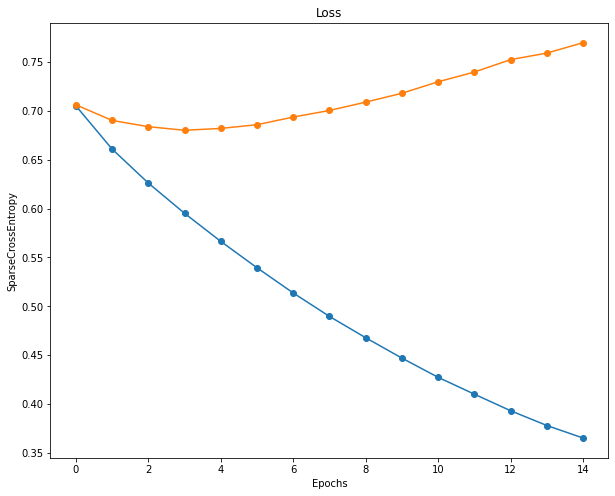

In [ ]:

plt.close()
plt.figure(figsize=(10,8))
plt.plot(np.arange(15),train_loss,'-o')
plt.plot(np.arange(15),val_loss, '-o')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("SparseCrossEntropy")
plt.show()

[-0.9311735365125868, -0.6736610730489095, -0.6289268970489502]
-0.6289268970489502
Real Caption: <start> picture of fast moving car at dusk <end>
Prediction Caption: stop sign that is on the side of street <end>


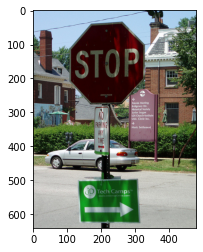

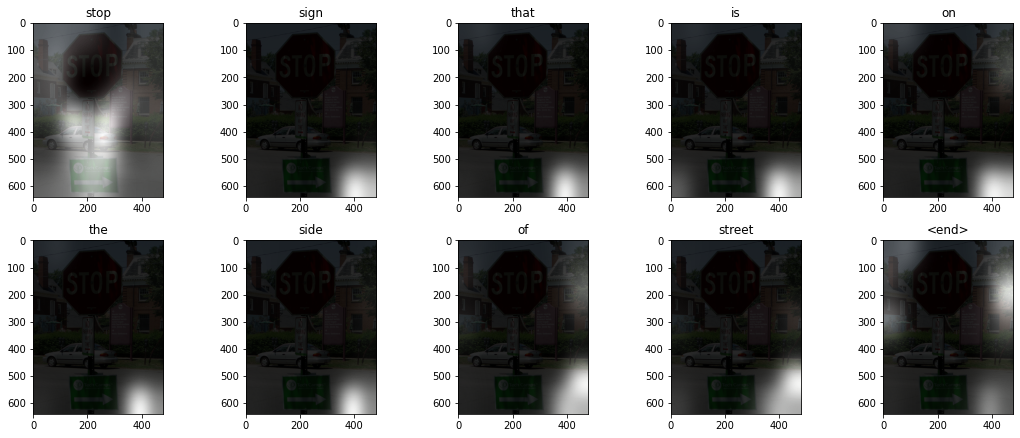

[-1.0047522650824652, -0.7600932554765181, -0.7486050923665365]
-0.7486050923665365
Real Caption: <start> two trains parallel to each other with dog between them <end>
Prediction Caption: train on the tracks in the middle of an arid area <end>


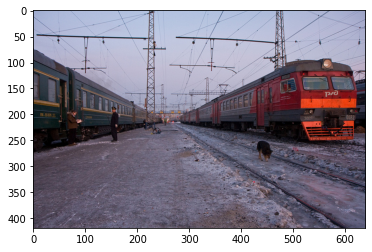

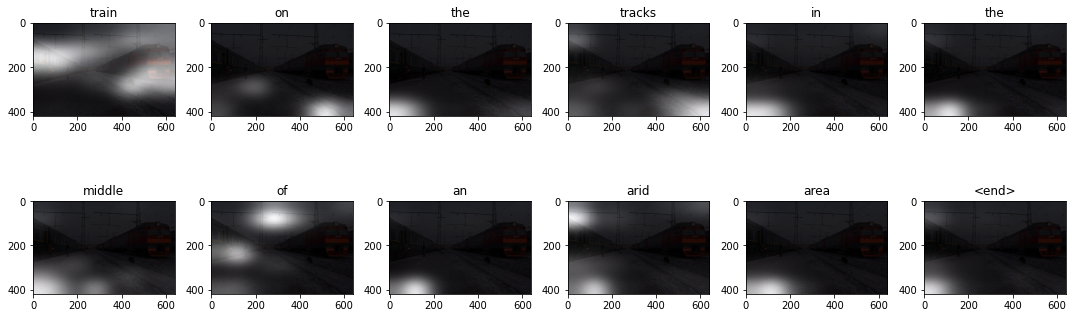

[-0.9643790381295341, -1.0421654837472099, -1.0070825815200806]
-0.9643790381295341
Real Caption: <start> baseball player that is attempting to steal base <end>
Prediction Caption: baseball player is sliding into base <end>


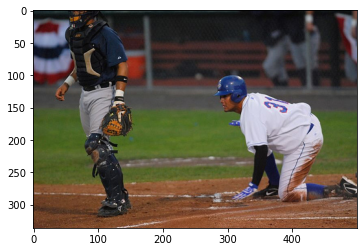

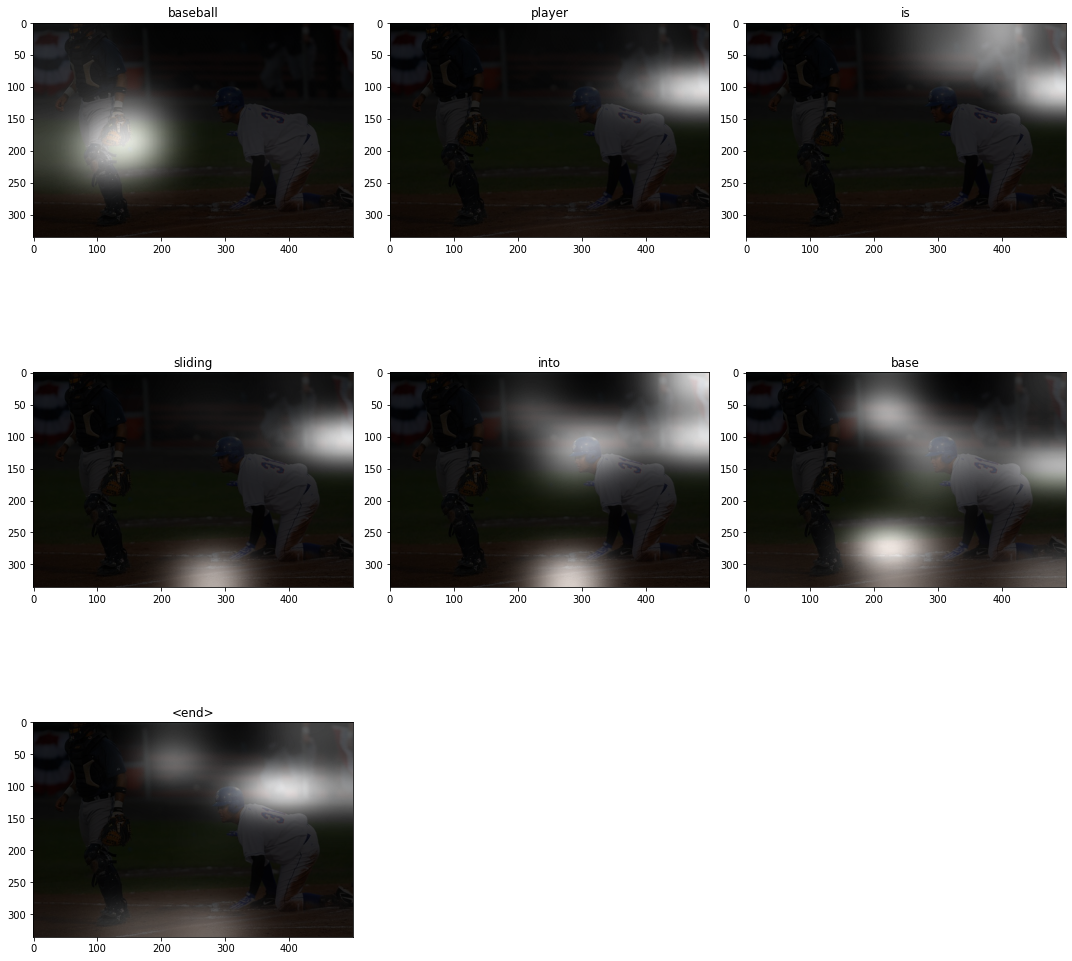

[-1.1975783109664917, -1.1137506484985351, -0.8788801540027965]
-0.8788801540027965
Real Caption: <start> black dog is carrying frisbee in its mouth on beach <end>
Prediction Caption: black dog is on beach with frisbee in its mouth <end>


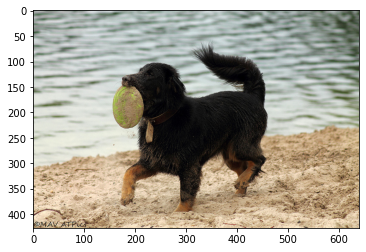

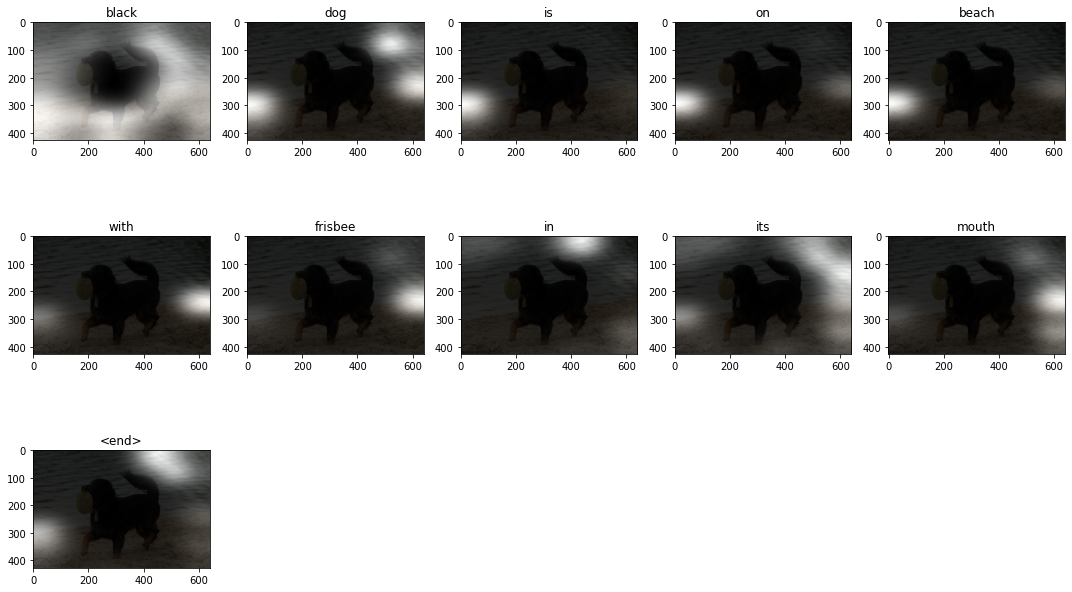

[-0.9088765250311958, -0.9312930636935763, -0.7981231862848456]
-0.7981231862848456
Real Caption: <start> baby laying on bed with book <end>
Prediction Caption: child laying on bed with sheet and pillows on it <end>


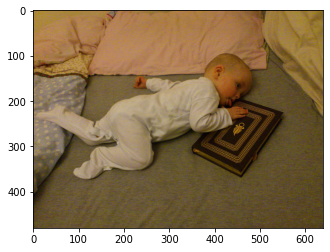

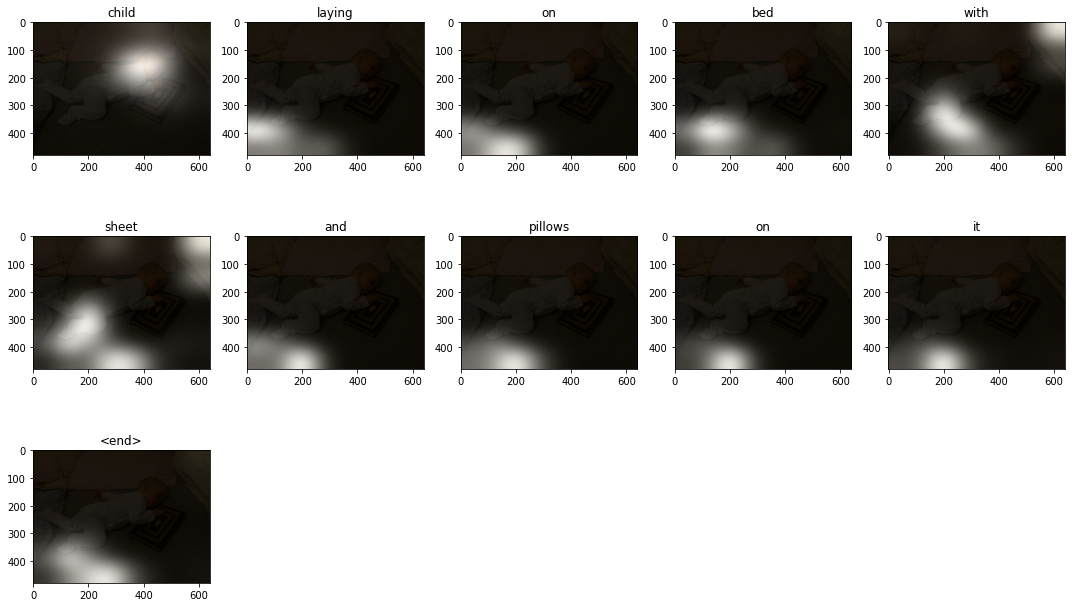

[-0.5568498969078064, -0.6842457294464112, -0.8350021362304687]
-0.5568498969078064
Real Caption: <start> three different pictures of men serving tennis balls <end>
Prediction Caption: man holding tennis racquet on tennis court <end>


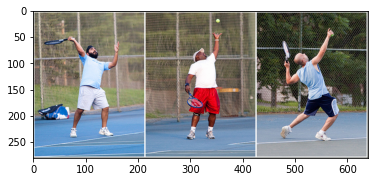

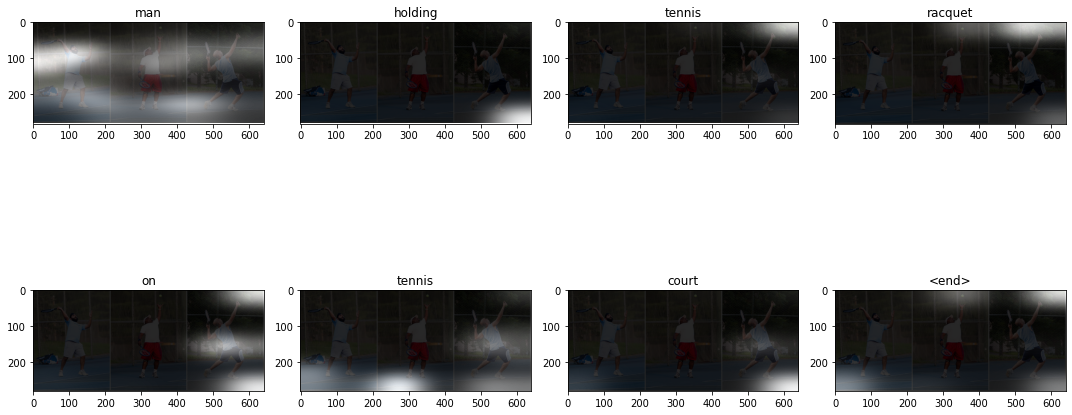

In [ ]:
# captions on the validation set
random_val_img = k
image_tensor = image_features_ectract_model(tf.expand_dims(load_image(t)[0],0))
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[random_val_img] if i not in [0]])
result, attention_plot = result_attention(beam_search(image_tensor))

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plt.imshow(np.array(Image.open(load_image(t)[1])))
plot_attention(load_image(t)[1], result, attention_plot)

 t = "/content/train2014/COCO_train2014_000000496683.jpg"
k = 8437

/content/train2014/COCO_train2014_000000235464.jpg
9813

/content/train2014/COCO_train2014_000000235464.jpg
8592

/content/train2014/COCO_train2014_000000246918.jpg
164

/content/train2014/COCO_train2014_000000528961.jpg
224

/content/train2014/COCO_train2014_000000062272.jpg
9569

/content/train2014/COCO_train2014_000000120882.jpg
4715

In [ ]:
import numpy as np

In [ ]:
kk = np.array([[[1,2,3],[4,5,6]], [[11,22,33],[44,55,66]], [[111,222,333],[444,555,666]]])
kk

array([[[  1,   2,   3],
        [  4,   5,   6]],

       [[ 11,  22,  33],
        [ 44,  55,  66]],

       [[111, 222, 333],
        [444, 555, 666]]])

In [ ]:
kk.shape

(3, 2, 3)

In [ ]:
kk.reshape((-1,3))

array([[  1,   2,   3],
       [  4,   5,   6],
       [ 11,  22,  33],
       [ 44,  55,  66],
       [111, 222, 333],
       [444, 555, 666]])